# Preparing a TensorFlow 2 model for serving with TF Serving

This notebook demonstrates how to prepare a TensorFlow 2.x model for serving with AI Platform Prediction Custom Containers (Beta) and [TF Serving](https://www.tensorflow.org/tfx/guide/serving). 

The inputs and outputs of the model as used during model training may not be optimal for serving. For example, in a typical training pipeline, feature engineering is performed as a separate step preceding model training and hyperparameter tuning. When serving the model, it may be more optimal to embed the feature engineering logic into the serving interface rather than require a client application to preprocess data.

This notebook uses the pretrained [ResNet V2 101](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4) image classification model from [TF Hub](https://tfhub.dev/). The demonstrated patterns and practices can be easily generalized to other types of TensorFlow 2 models.



In [21]:
import base64
import os
import json
import requests
import time
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from typing import List, Optional, Text, Tuple

## Setting up the environment

This notebook was tested on **AI Platform Notebooks** using the standard TF 2.2 image. 

### Set the model store path

Update the `GCS_MODEL_STORE` constant with the name of the GCS path to store the model created later in this notebook. 

In [23]:
GCS_MODEL_STORE = 'gs://mlops-dev-workspace/models'

### Set the urls to TF Hub assets

In [24]:
THUB_MODEL_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4'
IMAGENET_LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'

### Create a local workspace

In [25]:
LOCAL_WORKSPACE = '/tmp/workspace'
if tf.io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf.io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf.io.gfile.makedirs(LOCAL_WORKSPACE)

Removing previous workspace artifacts...
Creating a new workspace...


## Loading and running the ResNet v2 101 model

### Download and instantiate the model

In [26]:
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = 'True'

local_savedmodel_path = hub.resolve(THUB_MODEL_HANDLE)

print(local_savedmodel_path)
!ls -la {local_savedmodel_path}

/tmp/tfhub_modules/7b8093cf6e9836037eb01298256d50901c6e2cbb
total 2956
drwxr-xr-x 4 jupyter jupyter    4096 Aug 15 02:37 .
drwxr-xr-x 3 jupyter jupyter    4096 Aug 15 15:46 ..
drwxr-xr-x 2 jupyter jupyter    4096 Aug 15 02:37 assets
-rw-r--r-- 1 jupyter jupyter 3007213 Aug 15 02:37 saved_model.pb
drwxr-xr-x 2 jupyter jupyter    4096 Aug 15 02:37 variables


In [8]:
model = hub.load(THUB_MODEL_HANDLE)

The expected input to most TF Hub TF2 image classification models, including ResNet 101, is a rank 4 tensor conforming to the following tensor specification: `tf.TensorSpec([None, height, width, 3], tf.float32)`. For the ResNet 101 model, the expected image size is `height x width = 224 x 224`. The color values for all channels are expected to be normalized to the [0, 1] range. 

The output of the model is a batch of logits vectors. The indices into the logits are the `num_classes = 1001` classes  from the ImageNet dataset. The mapping from indices to class labels can be found in the [labels file](download.tensorflow.org/data/ImageNetLabels.txt) with class 0 for "background", followed by 1000 actual ImageNet classes.
    

### Test the model

We will now test the model on a couple of JPEG images. 

#### Display sample images

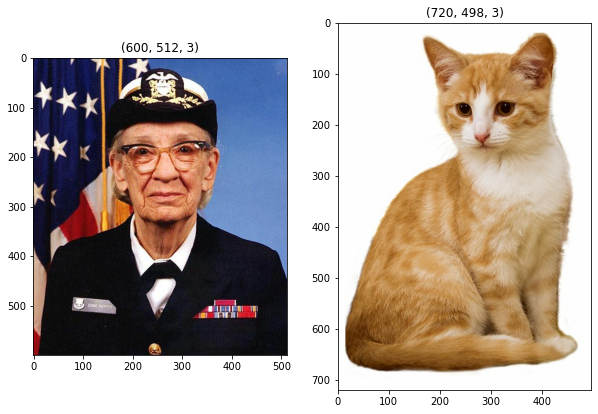

In [27]:
image_folder = 'test_images'
image_list = [tf.io.read_file(os.path.join(image_folder, image_path))
         for image_path in os.listdir(image_folder)]

ncolumns = len(image_list) if len(image_list) < 4 else 4
nrows = int(len(image_list) // ncolumns)
fig, axes = plt.subplots(nrows=nrows, ncols=ncolumns, figsize=(10,10))
for axis, image in zip(axes.flat[0:], image_list):
    decoded_image = tf.image.decode_image(image)
    axis.set_title(decoded_image.shape)
    axis.imshow(decoded_image.numpy())

#### Preprocess the testing images

The images need to be preprocessed to conform to the format expected by the ResNet101 model.

In [28]:
def _decode_and_scale(image, size):
    image = tf.image.decode_image(image, expand_animations=False)
        
    image_height = image.shape[0]
    image_width = image.shape[1]
    crop_size = tf.minimum(image_height, image_width)
    offset_height = ((image_height - crop_size) + 1) // 2
    offset_width = ((image_width - crop_size) + 1) // 2
        
    image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_size, crop_size)
    image = tf.cast(tf.image.resize(image, [size, size]), tf.uint8)
    
    return image

In [29]:
size = 224

raw_images = tf.stack(image_list)
preprocessed_images = tf.map_fn(lambda x: _decode_and_scale(x, size), raw_images, dtype=tf.uint8)
preprocessed_images = tf.image.convert_image_dtype(preprocessed_images, tf.float32)
print(preprocessed_images.shape)

(2, 224, 224, 3)


#### Run inference

In [30]:
predictions = model(preprocessed_images)
predictions

<tf.Tensor: shape=(2, 1001), dtype=float32, numpy=
array([[ 0.281632  ,  0.61440957, -0.00329547, ..., -0.59479165,
        -0.05206643, -0.11485152],
       [ 0.2737472 , -1.2126322 , -0.8585855 , ..., -1.8846446 ,
         0.2523733 ,  1.8259859 ]], dtype=float32)>

The model returns a batch of arrays with logits. This is not a very user friendly output so we will convert it to the list of ImageNet class labels.

#### Download ImageNet labels

In [31]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    IMAGENET_LABELS_URL)
imagenet_labels = np.array(open(labels_path).read().splitlines())

#### Map the logits to class labels

We will display the 5 highest ranked labels for each image

In [32]:
for prediction in list(predictions):
    decoded = imagenet_labels[np.argsort(prediction.numpy())[::-1][:5]]
    print(list(decoded))

['military uniform', 'suit', 'Windsor tie', 'pickelhaube', 'bow tie']
['Egyptian cat', 'tiger cat', 'tabby', 'lynx', 'Siamese cat']


## Preparing the model for TF Serving

The ResNet V2 101 model from TF HUB is optimized for recomposition and fine tuning. Since there are no serving signatures in the model's metadata, it cannot be served with TF Serving as is.

In [33]:
list(model.signatures)

[]

To make it servable, we need to add a serving signature(s) describing the inference method(s) of the model. 

We will add two signatures. The default signature will expose the default predict method of the ResNet101 model.

Since the expected inputs to this interface require a relatively complex image preprocessing to be performed by a client, we will also expose an alternative signature that embeds the preprocessing and postprocessing logic and accepts raw unprocessed images and returns the list of ranked class labels and associated label probabilities. 

This is achieved by defining a custom module class derived from the `tf.Module` base class that encapsulates our ResNet model and extends it with a method implementing the image preprocessing and output postprocessing logic. The default method of the custom module is mapped to the default method of the base ResNet module to maintain the analogous interface. 

The custom module will be exported as `SavedModel` that includes the original model, the preprocessing logic, and two serving signatures.

This technique can be generalized to other scenarios where you need to extend a TensorFlow model and you have access to the serialized `SavedModel` but you don't have access to the Python code implementing the model.


#### Define the custom serving module

In [34]:
LABELS_KEY = 'labels'
PROBABILITIES_KEY = 'probabilities'
NUM_LABELS = 5

class ServingModule(tf.Module):
    """
    A custom tf.Module that adds image preprocessing and output post processing to
    a base TF 2 image classification model from TF Hub. 
    """

    def __init__(self, base_model, input_size, output_labels):
        super(ServingModule, self).__init__()
        self._model = base_model
        self._input_size = input_size
        self._output_labels = tf.constant(output_labels, dtype=tf.string)
        

    def _decode_and_scale(self, raw_image):
        """
        Decodes, crops, and resizes a single raw image.
        """
        
        image = tf.image.decode_image(raw_image, dtype=tf.dtypes.uint8, expand_animations=False)
        image_shape = tf.shape(image)
        image_height = image_shape[0]
        image_width = image_shape[1]
        crop_size = tf.minimum(image_height, image_width)
        offset_height = ((image_height - crop_size) + 1) // 2
        offset_width = ((image_width - crop_size) + 1) // 2
        
        image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_size, crop_size)
        image = tf.image.resize(image, [self._input_size, self._input_size])
        image = tf.cast(image, tf.uint8)
    
        return image
    
    def _preprocess(self, raw_inputs):
        """
        Preprocesses raw inputs as sent by the client.
        """
        
        # A mitigation for https://github.com/tensorflow/tensorflow/issues/28007
        with tf.device('/cpu:0'):
            images = tf.map_fn(self._decode_and_scale, raw_inputs, dtype=tf.uint8)
        images = tf.image.convert_image_dtype(images, tf.float32)
        
        return images
        
    def _postprocess(self, model_outputs):
        """
        Postprocesses outputs returned by the base model.
        """
        
        probabilities = tf.nn.softmax(model_outputs)
        indices = tf.argsort(probabilities, axis=1, direction='DESCENDING')
        
        return {
            LABELS_KEY: tf.gather(self._output_labels, indices, axis=-1)[:,:NUM_LABELS],
            PROBABILITIES_KEY: tf.sort(probabilities, direction='DESCENDING')[:,:NUM_LABELS]
        }
        

    @tf.function(input_signature=[tf.TensorSpec([None, 224, 224, 3], tf.float32)])
    def __call__(self, x):
        """
        A pass-through to the base model.
        """
        
        return self._model(x)

    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def predict_labels(self, raw_images):
        """
        Preprocesses inputs, calls the base model 
        and postprocesses outputs from the base model.
        """
        
        # Call the preprocessing handler
        images = self._preprocess(raw_images)
        
        # Call the base model
        logits = self._model(images)
        
        # Call the postprocessing handler
        outputs = self._postprocess(logits)
        
        return outputs
        
    
serving_module = ServingModule(model, 224, imagenet_labels)

#### Test the custom serving module

In [35]:
predictions = serving_module.predict_labels(raw_images)
predictions

{'labels': <tf.Tensor: shape=(2, 5), dtype=string, numpy=
 array([[b'military uniform', b'suit', b'Windsor tie', b'pickelhaube',
         b'bow tie'],
        [b'Egyptian cat', b'tiger cat', b'tabby', b'lynx', b'Siamese cat']],
       dtype=object)>,
 'probabilities': <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[9.3996829e-01, 4.8564855e-02, 6.4148935e-03, 2.0145320e-03,
         6.0497446e-04],
        [8.2705313e-01, 1.3128281e-01, 4.1055076e-02, 5.7081401e-04,
         1.8924819e-05]], dtype=float32)>}

#### Save the custom serving module as `SavedModel`

In [36]:
model_name = 'resnet_serving'
model_version = '1'
model_path = os.path.join(LOCAL_WORKSPACE, model_name, model_version)

default_signature = serving_module.__call__.get_concrete_function()
preprocess_signature = serving_module.predict_labels.get_concrete_function()
signatures = {
    'serving_default': default_signature,
    'serving_preprocess': preprocess_signature
}

tf.saved_model.save(serving_module, model_path, signatures=signatures)

INFO:tensorflow:Assets written to: /tmp/workspace/resnet_serving/1/assets


INFO:tensorflow:Assets written to: /tmp/workspace/resnet_serving/1/assets


#### Inspect the `SavedModel`

In [37]:
!saved_model_cli show --dir {model_path} --tag_set serve --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['x'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1001)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

signature_def['serving_preprocess']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['raw_images'] tensor

## Test the custom serving module with TF Serving

We will now run the exported custom serving module using the TF Serving docker image.

### Start the TF Serving server:

To start the *TF Serving* server and expose the *TF Serving* REST API port (8501):

1. Open a JupyterLab terminal.
2. Pull the latest TF Serving docker image.

```
docker pull tensorflow/serving
```


4. Set the environment variables for the model's name and the model's path. Use the value printed by the next cell for the model's path.

```
export MODEL_PATH=[YOUR_MODEL_PATH]
export MODEL_NAME=resnet
```

In [38]:
print(model_path[:-2])

/tmp/workspace/resnet_serving


3. Start the server and register your custom module for serving

```
docker run -it --rm -p 8501:8501 \
-v $MODEL_PATH:/models/$MODEL_NAME \
-e MODEL_NAME=$MODEL_NAME \
tensorflow/serving 
```



### Run inference

We will now run inference by invoking the TF Serving `Predict` API.

Refer to the [TF Serving REST API Reference](https://www.tensorflow.org/tfx/serving/api_rest) for more information about the API format.

#### Invoke the model using the `serving_preprocess` signature

Load sample images

In [39]:
image_folder = 'test_images'
image_list = [tf.io.read_file(os.path.join(image_folder, image_path))
         for image_path in os.listdir(image_folder)]

Encode the images using base 64 encoding.

In [40]:
raw_images_as_list = [{'b64': base64.b64encode(image.numpy()).decode('utf-8')} for image in image_list]

Prepare the request body and headers.

In [41]:
request_body = {
    'signature_name': 'serving_preprocess',
    'instances': raw_images_as_list
}

headers = {"content-type": "application/json"}

Invoke the `Predict` endpoint and display results.

In [42]:
uri = 'http://localhost:8501/v1/models/resnet:predict'

response = requests.post(uri, data=json.dumps(request_body))

response.json()

{'predictions': [{'labels': ['military uniform',
    'suit',
    'Windsor tie',
    'pickelhaube',
    'bow tie'],
   'probabilities': [0.940013289,
    0.0485328734,
    0.00640666,
    0.00201300764,
    0.000604339584]},
  {'labels': ['Egyptian cat', 'tiger cat', 'tabby', 'lynx', 'Siamese cat'],
   'probabilities': [0.827053308,
    0.131282583,
    0.0410549268,
    0.000570811506,
    1.89247112e-05]}]}

#### Invoke the model using the `serving_default` signature

Preprocess the raw images.

In [43]:
size = 224

raw_images = tf.stack(image_list)
preprocessed_images = tf.map_fn(lambda x: _decode_and_scale(x, size), raw_images, dtype=tf.uint8)
preprocessed_images = tf.image.convert_image_dtype(preprocessed_images, tf.float32)
print(preprocessed_images.shape)

(2, 224, 224, 3)


Prepare the request body and headers.

In [44]:
images_as_list = preprocessed_images.numpy().tolist()

request_body = {
    'signature_name': 'serving_default',
    'instances': images_as_list
}

headers = {"content-type": "application/json"}

Invoke the `Predict` endpoint and display results.

In [45]:
uri = 'http://localhost:8501/v1/models/resnet:predict'

response = requests.post(uri, data=json.dumps(request_body))

print(str(response.json())[0:200], '...')

{'predictions': [[0.28163141, 0.614411712, -0.00329366326, 0.873328269, -0.783175826, -0.431026816, -0.0673072636, -0.836482167, -0.432366759, 0.229343504, -1.22413266, -0.388189197, 0.706549644, -0.0 ...


### Stop the TF Serving container

1. Open a new JupyterLab terminal.
2. Get the ID of your TF Serving container

```
docker ps
```
3. Terminate your TF Serving container

```
docker kill [YOUR_CONTAINER_ID]
```


## Copy the custom serving module to GCS

In [46]:
local_path = os.path.join(LOCAL_WORKSPACE, model_name)

!gsutil cp -r {local_path} {GCS_MODEL_STORE}

Copying file:///tmp/workspace/resnet_serving/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///tmp/workspace/resnet_serving/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///tmp/workspace/resnet_serving/1/variables/variables.index [Conte

In [47]:
!gsutil ls {GCS_MODEL_STORE}

gs://mlops-dev-workspace/models/covertype_classifier/
gs://mlops-dev-workspace/models/resnet_serving/


## Next Steps

Walk through the `aipp_deploy.ipynb` notebook to learn how to deploy the custom serving module created in this notebook to **AI Platform Prediction** using TF Serving container image.

## License

<font size=-1>Licensed under the Apache License, Version 2.0 (the \"License\");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  See the License for the specific language governing permissions and limitations under the License.</font>